# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.omf import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon import Lexicon_FR_updated as lexicon_fr
from utils.io import boreholes_from_files, striplog_from_text,gdf_viewer,\
df_from_sources, striplog_from_df
from core.core import Project
from core.orm import BoreholeOrm, PositionOrm, Base 

import matplotlib.pyplot as plt
from os import remove
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
search_dir=ROOT_DIR+'/CF_data/Result_traitem/'
#cols=['ID','X','Y','Z','Long_for','Diam_for']
#filename='source_Boreholes'

In [3]:
df=pd.read_csv(search_dir+'profils_sols_donnees_forages/source_Lithology.csv', delimiter=',')

In [4]:
df1=pd.read_csv(search_dir+'profils_sols_donnees_forages/source_Boreholes.csv', delimiter=',')

In [5]:
df
#gdf_viewer(df1)

,ID,Litho_top,Litho_base,Keyword,Description
0,F1aM,0.0,0.5,Terre arable,Limon brun
1,F1aM,0.5,1.2,Remblais déchets sidérurgiques,"Remblais sableux avec charge pierreuse, couleu..."
2,F1aM,1.2,2.4,Remblais déchets sidérurgiques,"Remblais hétérogène, strate noire avec présenc..."
3,F2M,0.0,2.4,Remblais déchets sidérurgiques,Remblais hétérogène gris foncé avec charge pie...
4,F2M,2.4,4.0,Remblais déchets sidérurgiques,Remblais hétérogène gris foncé avec charge pie...
5,F2M,4.0,6.0,Limon argileux,Début des limons argileux verdâtre/brun vers 4...
6,F3M,0.0,0.2,Béton,Béton
7,F3M,0.2,0.3,Sable,Stabilisé beige
8,F3M,0.3,1.2,Remblais déchets sidérurgiques,Remblais hétérogène noir avec présence de briq...
9,F3M,1.2,3.3,Remblais déchets sidérurgiques,Remblais hétérogène gris foncé avec charge de ...


In [6]:
df_all=df1.merge(df, on='ID', how='inner')
df_all.Description.fillna('', inplace=True)
df_all
gdf_viewer(df_all[['ID','Litho_top','Litho_base','Description']], cols=10)

Rows : 15, columns : 4


interactive(children=(IntSlider(value=10, description='rows', max=15, min=10, readout=False), IntSlider(value=…

## Data Checking

## Create Boreholes from dataframes or files

In [7]:
df_all.loc[1, 'Description']='Remblais sableux avec charge pierreuse, couleur rouge '

In [8]:
lex=Lexicon(lexicon_fr.LEXICON)

In [9]:
bhs_df=[df_all]

In [10]:
boreholes, components, link_intv_comp = boreholes_from_files(bhs_df, verbose=True,
                                                litho_field='Description',
                                                lexicon=lex,
                                            diam_field='Diam_for', 
                                            length_field='Long_for')


Dataframe 0 processing...
length=2.40
length=2.40
length=2.40
|__ID:'F1aM' -- No lithology data, treated with default ('white sand')
{'F1aM': Striplog(3 Intervals, start=0.0, stop=2.4)}
{0: {'description': 'Limon brun ', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f06e419d790>, 'base': <core.orm.PositionOrm object at 0x7f06e419d040>}, 1: {'description': 'Remblais sableux avec charge pierreuse, couleur rouge ', 'interval_number': 1, 'top': <core.orm.PositionOrm object at 0x7f06e40a3cd0>, 'base': <core.orm.PositionOrm object at 0x7f06e40a3f70>}, 2: {'description': 'Remblais hétérogène, strate noire avec présence de scories, petite charge de briquaillons de déchets de construction orange/beige, présence de laitier induré à la base. ', 'interval_number': 2, 'top': <core.orm.PositionOrm object at 0x7f06e40a3970>, 'base': <core.orm.PositionOrm object at 0x7f06e4035070>}}

|__ID 'F1aM' already treated, skip
|__ID 'F1aM' already treated, skip
length=0.30
|__ID:'F7aM' -- No

In [11]:
boreholes

[<core.orm.BoreholeOrm>(id=F1aM, length=2.4, diameter=75, intervals=3),
 <core.orm.BoreholeOrm>(id=F7aM, length=2.4, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F7bM, length=2.4, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F8M, length=0.3, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F9aM, length=0.3, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F9bM, length=0.3, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F10M, length=0.4, diameter=75, intervals=2),
 <core.orm.BoreholeOrm>(id=F15aM, length=0.6, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F15a'M, length=2.0, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F17aM, length=2.0, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F17bM, length=0.8, diameter=75, intervals=1),
 <core.orm.BoreholeOrm>(id=F17cM, length=0.5, diameter=75, intervals=1)]

In [12]:
components

{0: Component({'lithology': 'remblais', 'modifier': 'sableux', 'colour': 'rouge'}),
 1: Component({'lithology': 'remblais', 'state': 'hétérogène', 'material': 'scories', 'colour': 'noire'}),
 2: Component({'lithology': 'limon'}),
 3: Component({'lithology': 'remblais', 'material': 'béton', 'modifier': 'sableuse', 'colour': 'gris'}),
 4: Component({'lithology': 'remblais', 'material': 'scories', 'modifier': 'sableuse', 'colour': 'gris foncé'}),
 5: Component({'lithology': 'remblais', 'material': 'scories', 'colour': 'noir'}),
 6: Component({'lithology': 'remblais', 'material': 'scories'}),
 7: Component({'lithology': 'remblais', 'state': 'hétérogène', 'material': 'laitier', 'colour': 'gris foncé'}),
 8: Component({'lithology': 'remblais', 'state': 'hétérogène', 'material': 'béton'}),
 9: Component({'lithology': 'remblais', 'state': 'hétérogènes', 'modifier': 'sableuse', 'colour': 'sableuse', 'grainsize': 'centimétrique'})}

In [13]:
len(boreholes), len(components)

(12, 10)

## Display the striplog and 3D view

### Display project boreholes

In [14]:
remove('tmp_files/tfe_orm_db.db')

In [15]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [16]:
Base.metadata.create_all(engine)

2021-05-04 15:23:44,209 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-05-04 15:23:44,210 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,212 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-05-04 15:23:44,213 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,214 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2021-05-04 15:23:44,215 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,216 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2021-05-04 15:23:44,216 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,217 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Positions")
2021-05-04 15:23:44,217 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,218 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Positions")
2021-05-04 15:23:44,219 INFO sqlalchemy.engine.base.Engine ()
2021-05-04

In [17]:
Session = sessionmaker(bind=engine)
session = Session()

In [18]:
p = Project(session)
p.add_components(components)

2021-05-04 15:23:44,265 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-05-04 15:23:44,267 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-05-04 15:23:44,267 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,271 INFO sqlalchemy.engine.base.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-05-04 15:23:44,271 INFO sqlalchemy.engine.base.Engine ((0, 'Remblais, sableux, rouge'), (1, 'Remblais, hétérogène, scories, noire'), (2, 'Limon'), (3, 'Remblais, béton, sableuse, gris'), (4, 'Remblais, scories, sableuse, gris foncé'), (5, 'Remblais, scories, noir'), (6, 'Remblais, scories'), (7, 'Remblais, hétérogène, laitier, gris foncé'), (8, 'Remblais, hétérogène, béton'), (9, 'Remblais, hétérogènes, sableuse, sableuse, centimétrique'))
2021-05-04 15:23:44,273 INFO sqlalchemy.engine.base.Engine COMMIT
2021-05-04 15:23:44,276 IN

Add boreholes into the project

In [19]:
for bh in boreholes:
    p.add_borehole(bh)

2021-05-04 15:23:44,281 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-05-04 15:23:44,282 INFO sqlalchemy.engine.base.Engine ((0, 0.0, 0.0, 0.0, 152883.878158, 122606.5786), (1, 2.4, 2.4, 2.4, 152883.878158, 122606.5786), (2, 0.0, 0.0, 0.0, 152883.878158, 122606.5786), (3, 2.4, 2.4, 2.4, 152883.878158, 122606.5786), (4, 0.0, 0.0, 0.0, 152883.878158, 122606.5786), (5, 2.4, 2.4, 2.4, 152883.878158, 122606.5786))
2021-05-04 15:23:44,283 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-05-04 15:23:44,284 INFO sqlalchemy.engine.base.Engine ('F1aM', 2.4, 75.0)
2021-05-04 15:23:44,286 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-05-04 15:23:44,287 INFO sqlalchemy.engine.base.Engine ((0, 'F1aM', 0, 'Limon brun ', 0, 1), (1, 'F1aM', 1, 'Remblais sableux avec ch

2021-05-04 15:23:44,398 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-05-04 15:23:44,398 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-05-04 15:23:44,399 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,400 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-05-04 15:23:44,400 INFO sqlalchemy.engine.base.Engine ('F7bM',)
2021-05-04 15:23:44,402 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".l

2021-05-04 15:23:44,540 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-05-04 15:23:44,541 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-05-04 15:23:44,541 INFO sqlalchemy.engine.base.Engine ()
2021-05-04 15:23:44,542 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-05-04 15:23:44,543 INFO sqlalchemy.engine.base.Engine ('F9bM',)
2021-05-04 15:23:44,543 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".l

2021-05-04 15:23:44,659 INFO sqlalchemy.engine.base.Engine (21,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-05-04 15:23:44,697 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-05-04 15:23:44,698 INFO sqlalchemy.engine.base.Engine (0.8, 'F15aM')
2021-05-04 15:23:44,699 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-05-04 15:23:44,700 INFO sqlalchemy.engine.base.Engine ("F15a'M", 2.0, 75.0)
2021-05-04 15:23:44,701 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-05-04 15:23:44,702 INFO sqlalchemy.engine.base.Engine ((22, 0.0, 0.0, 0.0, 152837.023313, 122617.511539), (23, 0.5, 0.5, 0.5, 152837.023313, 122617.511539))
2021-05-04 15:23:44,703 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, 

2021-05-04 15:23:44,835 INFO sqlalchemy.engine.base.Engine (27,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-05-04 15:23:44,873 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-05-04 15:23:44,873 INFO sqlalchemy.engine.base.Engine (1.4, 'F17bM')
2021-05-04 15:23:44,875 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-05-04 15:23:44,875 INFO sqlalchemy.engine.base.Engine ('F17cM', 0.5, 75.0)
2021-05-04 15:23:44,876 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-05-04 15:23:44,877 INFO sqlalchemy.engine.base.Engine ((28, 0.0, 0.0, 0.0, 152840.031071, 122651.243036), (29, 1.4, 1.4, 1.4, 152840.031071, 122651.243036))
2021-05-04 15:23:44,878 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, t

In [20]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-05-04 15:23:44,936 INFO sqlalchemy.engine.base.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-05-04 15:23:44,937 INFO sqlalchemy.engine.base.Engine ((0, 2, ''), (1, 0, ''), (2, 1, ''), (3, 3, ''), (4, 3, ''), (5, 3, ''), (6, 4, ''), (7, 5, '')  ... displaying 10 of 15 total bound parameter sets ...  (13, 9, ''), (14, 9, ''))
2021-05-04 15:23:44,939 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-05-04 15:23:44,940 INFO sqlalchemy.engine.base.Engine (1.4, 'F17cM')
2021-05-04 15:23:44,942 INFO sqlalchemy.engine.base.Engine COMMIT
2021-05-04 15:23:44,945 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-05-04 15:23:44,947 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-05-04 15:23:44,947 INFO sqlalchemy.engine.base.Engine ()


In [21]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes))

2021-05-04 15:23:44,953 INFO sqlalchemy.engine.base.Engine COMMIT
Boreholes in the project :  12


In [22]:
p.boreholes

2021-05-04 15:23:44,959 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-05-04 15:23:44,960 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-05-04 15:23:44,960 INFO sqlalchemy.engine.base.Engine ('F1aM',)
2021-05-04 15:23:44,961 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-05-04 15:23:44,962 INFO sqlalchemy.engine.base.Engine ('F1aM',)
2021-05-04 15:23:44,963 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter

2021-05-04 15:23:45,001 INFO sqlalchemy.engine.base.Engine ('F17bM',)
2021-05-04 15:23:45,002 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-05-04 15:23:45,003 INFO sqlalchemy.engine.base.Engine ('F17cM',)
2021-05-04 15:23:45,004 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-05-04 15:23:45,004 INFO sqlalchemy.engine.base.Engine ('F17cM',)


[<core.orm.BoreholeOrm>(id=F1aM, length=2.4, diameter=75.0, intervals=3),
 <core.orm.BoreholeOrm>(id=F7aM, length=0.3, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F7bM, length=0.3, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F8M, length=0.3, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F9aM, length=0.4, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F9bM, length=0.6, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F10M, length=2.0, diameter=75.0, intervals=2),
 <core.orm.BoreholeOrm>(id=F15aM, length=0.8, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F15a'M, length=0.5, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F17aM, length=0.8, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F17bM, length=1.4, diameter=75.0, intervals=1),
 <core.orm.BoreholeOrm>(id=F17cM, length=1.4, diameter=75.0, intervals=1)]

In [23]:
p.refresh(verbose=True)

2021-05-04 15:23:45,012 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-05-04 15:23:45,014 INFO sqlalchemy.engine.base.Engine ()


In [24]:
session.close()

2021-05-04 15:23:45,018 INFO sqlalchemy.engine.base.Engine ROLLBACK


In [25]:
p.boreholes_3d[0].intervals # problem with top and base position --> kind of overlaying

[Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'base': Position({'middle': 2.4, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'description': 'Limon brun ', 'data': {}, 'components': [Component({'lithology': 'limon'})]}),
 Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'base': Position({'middle': 2.4, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'description': 'Remblais sableux avec charge pierreuse, couleur rouge ', 'data': {}, 'components': [Component({'lithology': 'remblais', 'modifier': 'sableux', 'colour': 'rouge'})]}),
 Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'base': Position({'middle': 2.4, 'x': 152883.878158, 'y': 122606.5786, 'units': 'm'}), 'description': 'Remblais hétérogène, strate noire avec présence de scories, petite cha

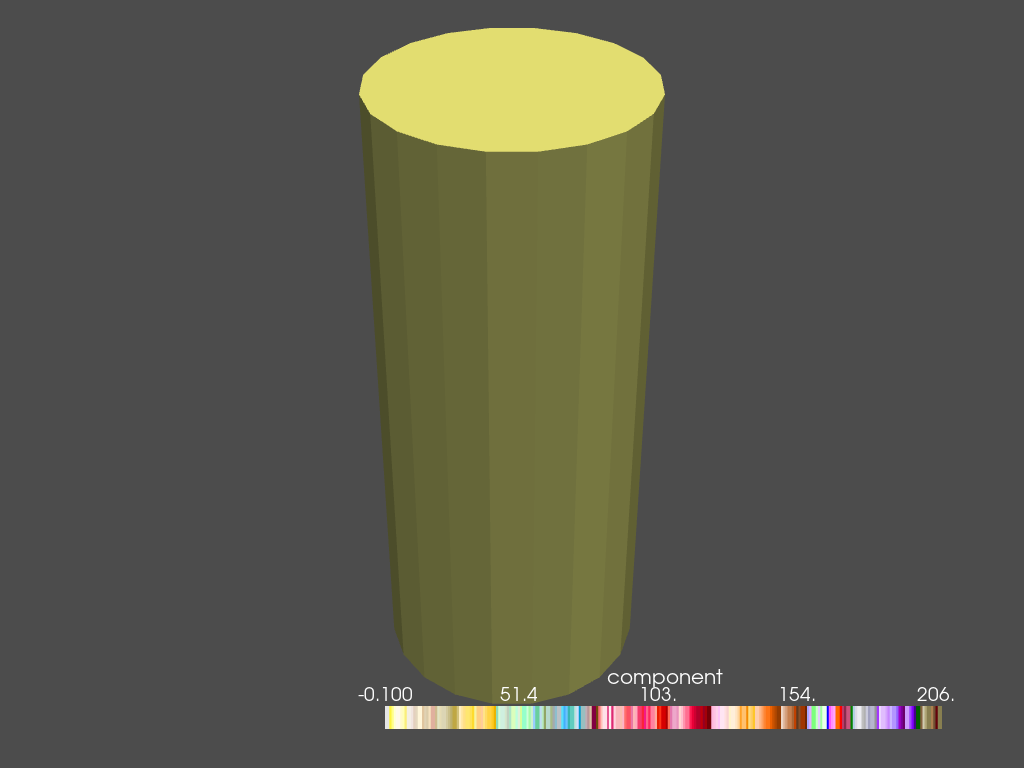

In [26]:
p.boreholes_3d[0].plot3d()

### The Borehole in 3D using X3D for interaction within the notebook

In [27]:
p.plot3d(x3d=True)